# Лабораторная работа 8, Лохматов Никита Игоревич М8О-406Б-21

## 1. Выбор начальных условий

### a. Набор данных для YOLO: smoke-fire-detection-yolo 

В выбранном датасете представлены реальные изображения различных сцен: как с присутствием дыма или огня, так и без них. Данные размечены для задачи классификации, что позволяет строить эффективные модели для раннего обнаружения признаков возгорания на видеокамерах наблюдения.

Преимуществами данного датасета являются:

- практическая значимость задачи (профилактика пожаров);
- разнообразие условий съёмки и объектов (разные локации, освещение, типы задымления/огня);
- рименимость в реальных системах мониторинга и безопасности;
- возможность расширения задач — помимо классификации, датасет подходит для object detection и сегментации.

### b. Выбор метрик качества и обоснование

- mAP@0.5 (mean Average Precision при IoU=0.5) — это среднее значение точности по всем классам при пороге пересечения (IoU) между предсказанной и истинной рамками, равном 0.5. Эта метрика широко используется в задачах детекции объектов и наглядно показывает, насколько хорошо модель распознаёт объект даже при не самом строгом совпадении предсказания с реальной областью.

- mAP@0.5:0.95 — это среднее по mAP, вычисленное при разных порогах IoU: от 0.5 до 0.95 с шагом 0.05. Данная метрика даёт более строгую и комплексную оценку, проверяя, насколько хорошо модель определяет объект с разной степенью точности локализации. Такой подход рекомендуется современными стандартами (например, используется в соревнованиях COCO) и стимулирует разработку моделей, способных не только находить объекты, но и точно определять их границы.

## 2. Создание бейзлайна и оценка качества

### a. Обучение моделей

Импортируем библиотеки

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import torch.nn
import torch.optim
import torch.utils.data
import numpy as np
import segmentation_models_pytorch as smp
import torchinfo
import matplotlib.pyplot as plt
import albumentations
import os
import kagglehub
from tqdm import tqdm
from ultralytics import YOLO
import yaml
import os
from pprint import pprint
import cv2
import torchvision.transforms as T
from torchmetrics.detection.mean_ap import MeanAveragePrecision


from PIL import Image
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/separatrix/my_venv/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Скачиваем датасет

In [3]:
# Скачиваем датасет
path = kagglehub.dataset_download("sayedgamal99/smoke-fire-detection-yolo")

Загружаем датасет


In [4]:
model = YOLO("yolo11n.pt")

with open(f"{path}/data.yaml", 'r') as file: data = yaml.safe_load(file)

data['train'] = f'{path}/data/train_5/images'
data['val']   = f'{path}/data/val_5/images'
data['test']  = f'{path}/data/test_5/images'

output_path = './updated_config.yml'

with open(output_path, 'w') as file: yaml.dump(data, file, default_flow_style=False)
     

Обучение модели

In [35]:
train_results = model.train(
    data=output_path,
    epochs=5,
    imgsz=480
)

Ultralytics 8.3.130 🚀 Python-3.13.3 torch-2.6.0 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./updated_config.yml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train72, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, pr

train: Scanning /Users/separatrix/.cache/kagglehub/datasets/sayedgamal99/smoke-fire-detection-yolo/versions/1/data/train_5/labels.cache... 706 images, 334 backgrounds, 0 corrupt: 100%|██████████| 706/706 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1614.6±1317.3 MB/s, size: 95.4 KB)



val: Scanning /Users/separatrix/.cache/kagglehub/datasets/sayedgamal99/smoke-fire-detection-yolo/versions/1/data/val_5/labels.cache... 154 images, 65 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

Plotting labels to runs/detect/train72/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 0 dataloader workers
Logging results to runs/detect/train72
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.673      2.391      1.456          0        480: 100%|██████████| 45/45 [02:08<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]

                   all        154        207      0.373      0.318      0.263      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      1.686       2.21      1.478          8        480: 100%|██████████| 45/45 [02:03<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

                   all        154        207      0.308      0.393      0.293      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      1.733      2.247      1.499          6        480: 100%|██████████| 45/45 [02:02<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

                   all        154        207      0.378      0.345       0.28      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      1.669       2.15      1.497          4        480: 100%|██████████| 45/45 [02:03<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]

                   all        154        207      0.278      0.396       0.27      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      1.655      2.114      1.478         15        480: 100%|██████████| 45/45 [02:03<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]

                   all        154        207      0.495      0.424      0.387      0.166

5 epochs completed in 0.185 hours.
Optimizer stripped from runs/detect/train72/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train72/weights/best.pt, 5.4MB

Validating runs/detect/train72/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.13.3 torch-2.6.0 CPU (Apple M3 Pro)


YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


                   all        154        207      0.495      0.424      0.387      0.166
                 smoke         82         88      0.424      0.545      0.449      0.202
                  fire         49        119      0.565      0.303      0.325       0.13
Speed: 0.2ms preprocess, 50.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train72


Визуализируем метрики

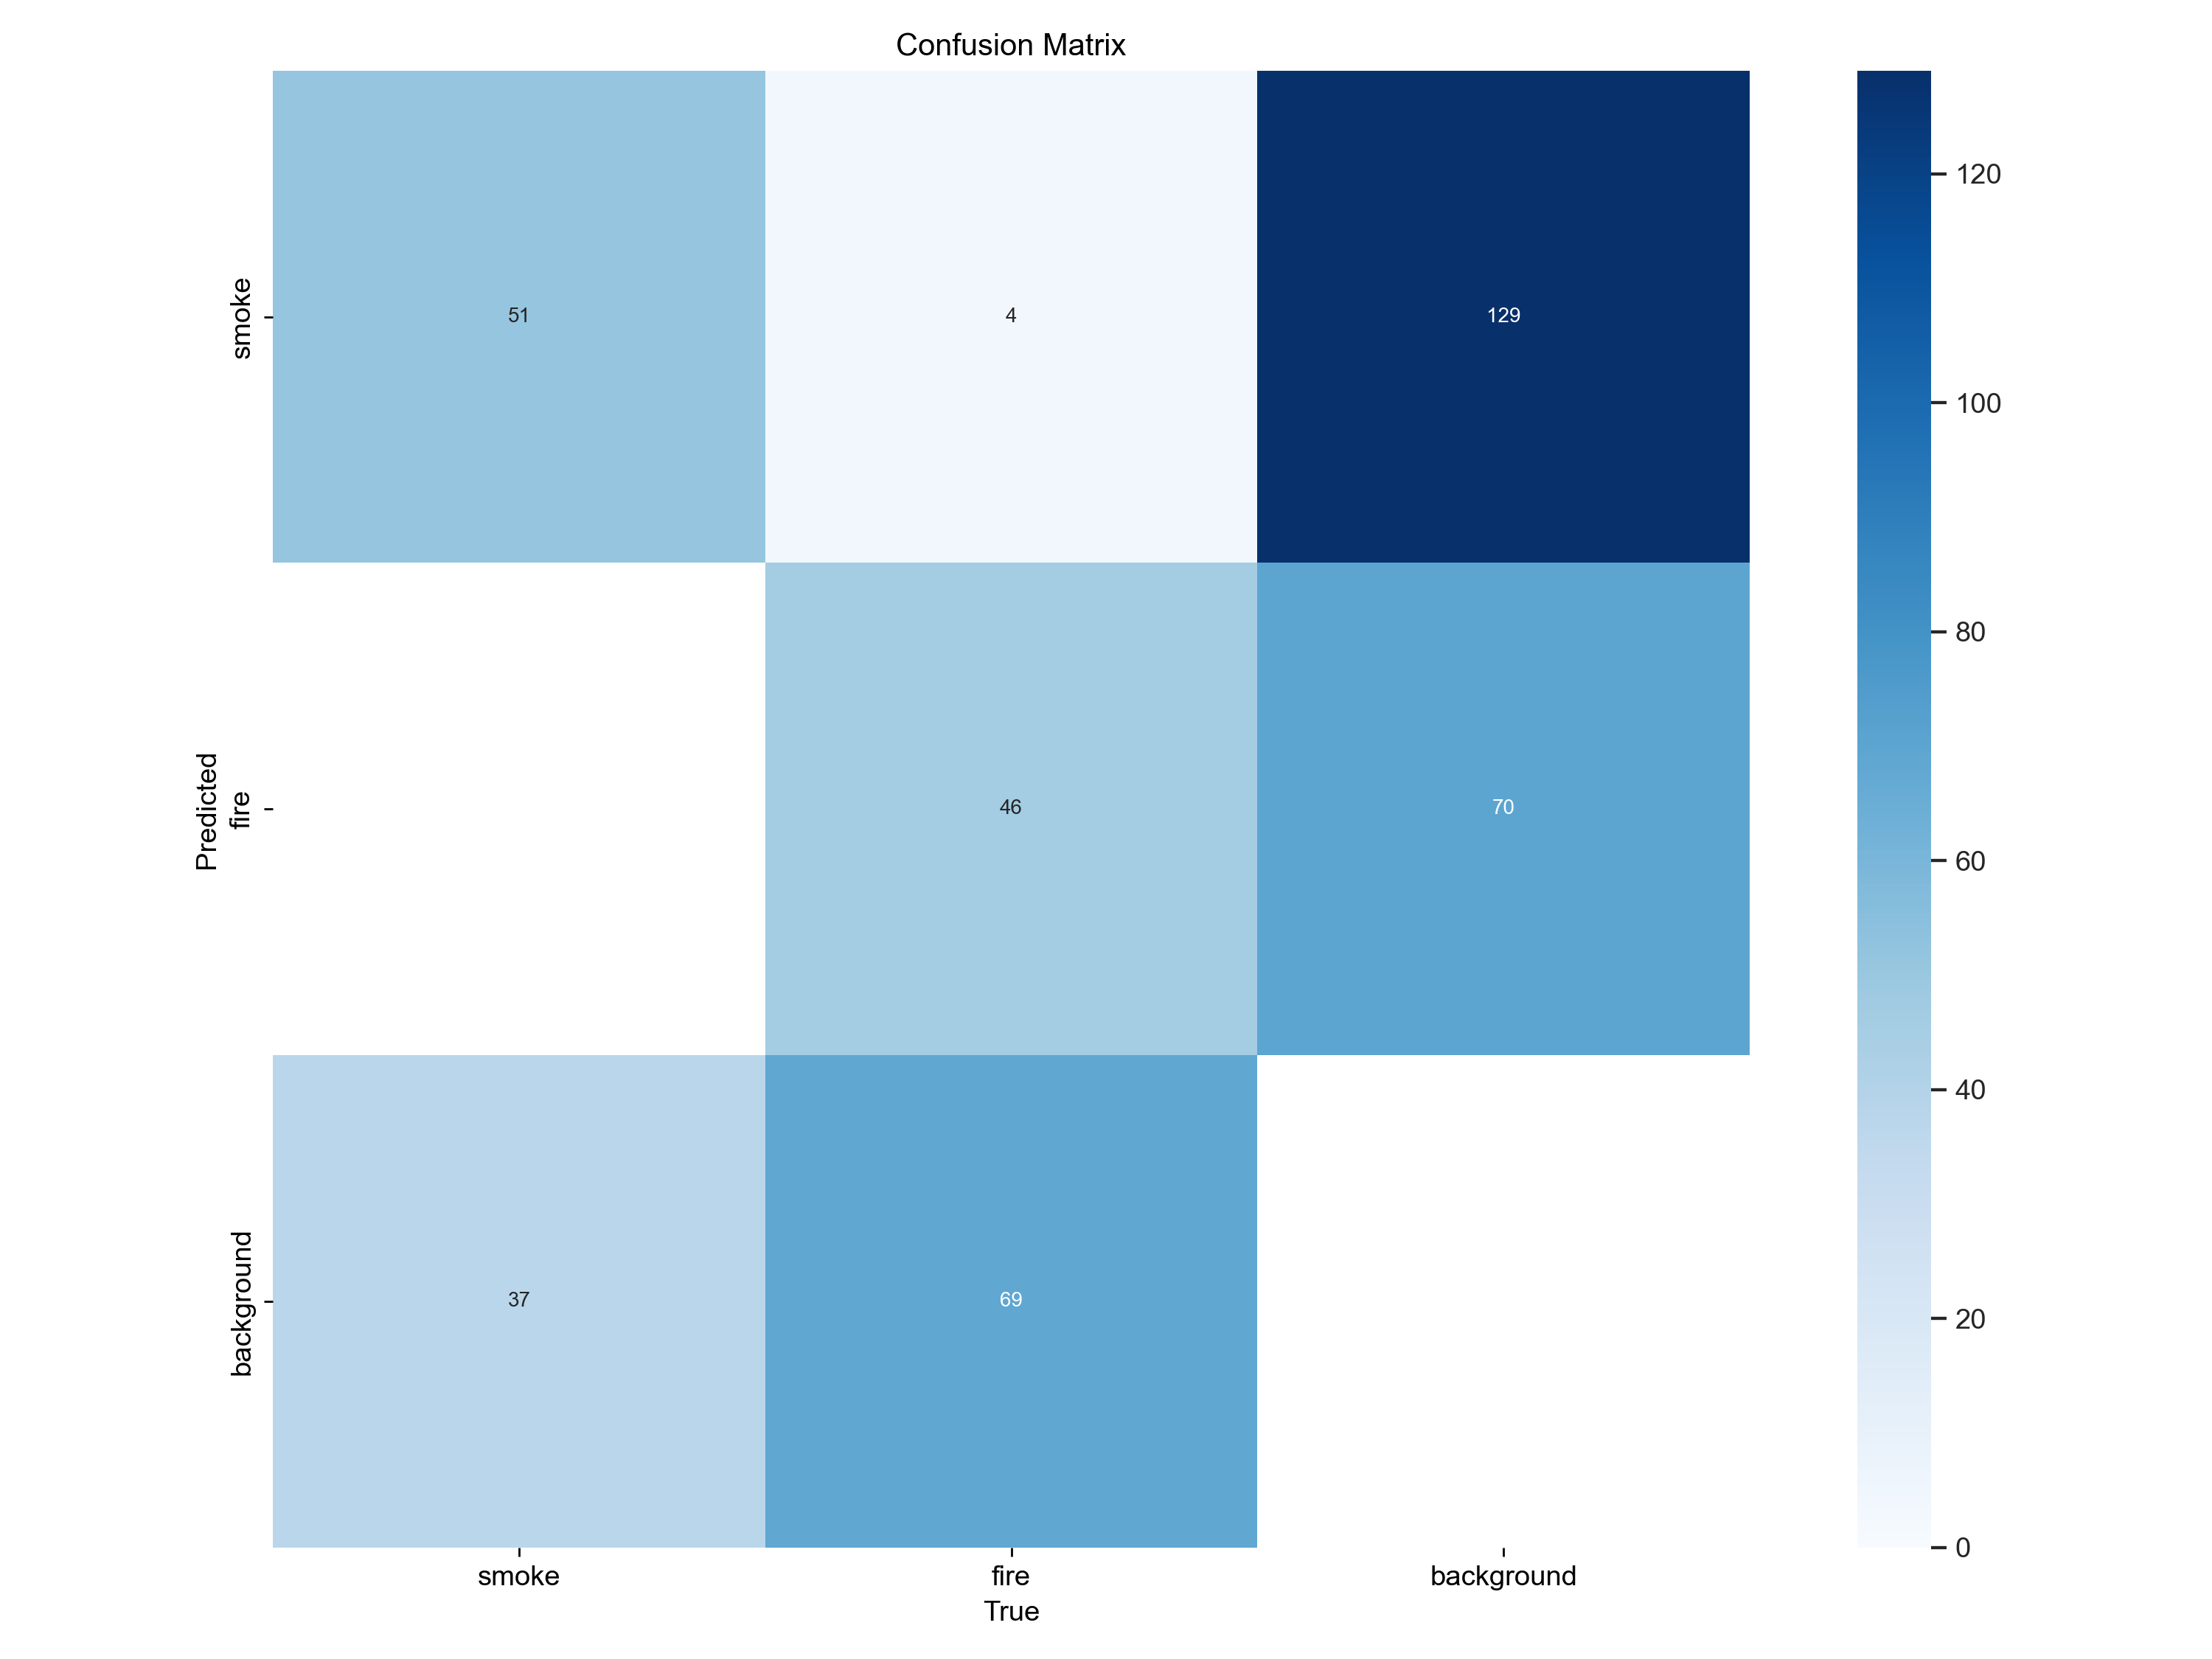

In [40]:
Image.open(f"runs/detect/train72/confusion_matrix.png")

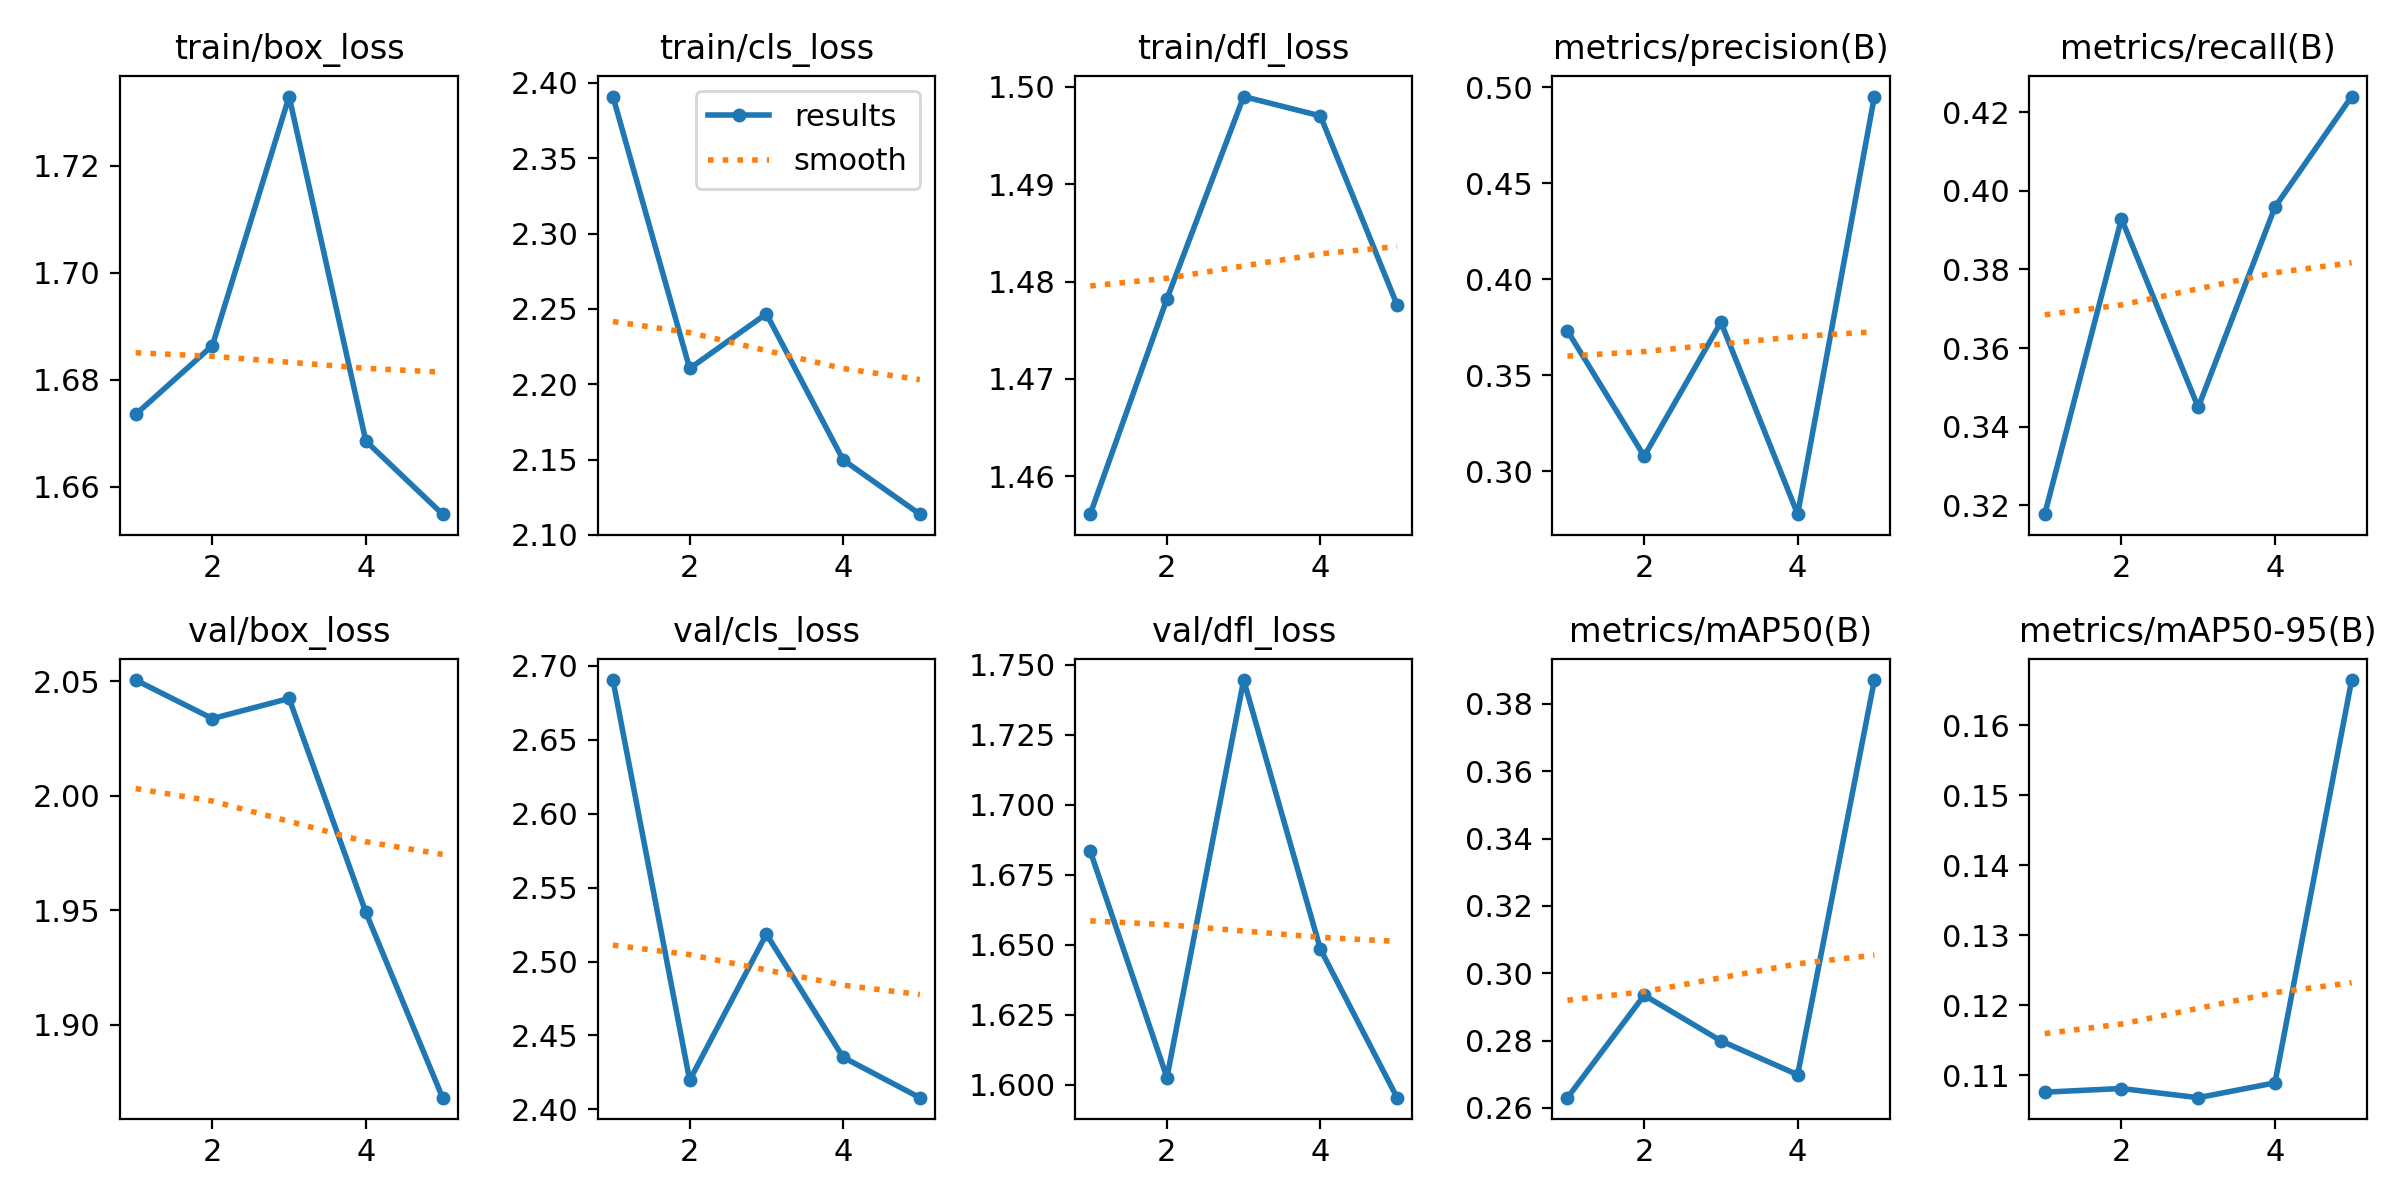

In [41]:
Image.open(f"runs/detect/train72/results.png")

## 3. Улучшение бейзлайна

### a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)


Для улучшения результатов я собираюсь увеличить количество эпох и размер изображения, а также добавить автоматическую аугментацию

### b. Проверка гипотез

In [45]:
model_s = YOLO('yolov8s.pt')
results_s = model_s.train(
    data=output_path, epochs=10, imgsz=640, batch=8,
    name='yolov8s_fire_aug',
    augment=True,
    lr0=0.01
)


Ultralytics 8.3.130 🚀 Python-3.13.3 torch-2.6.0 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./updated_config.yml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_fire_aug3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

train: Scanning /Users/separatrix/.cache/kagglehub/datasets/sayedgamal99/smoke-fire-detection-yolo/versions/1/data/train_5/labels.cache... 706 images, 334 backgrounds, 0 corrupt: 100%|██████████| 706/706 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2656.3±982.0 MB/s, size: 95.4 KB)



val: Scanning /Users/separatrix/.cache/kagglehub/datasets/sayedgamal99/smoke-fire-detection-yolo/versions/1/data/val_5/labels.cache... 154 images, 65 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolov8s_fire_aug3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8s_fire_aug3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.158      5.299      2.013          1        640: 100%|██████████| 89/89 [04:16<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

                   all        154        207     0.0944      0.287     0.0504     0.0149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/10         0G      2.454      3.644      2.352          2        640: 100%|██████████| 89/89 [04:19<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

                   all        154        207      0.055      0.191     0.0271    0.00795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/10         0G      2.556      3.396      2.459          0        640: 100%|██████████| 89/89 [04:23<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.10s/it]

                   all        154        207      0.571      0.113     0.0502     0.0178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/10         0G      2.624      3.407      2.494          1        640: 100%|██████████| 89/89 [04:26<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.20s/it]

                   all        154        207     0.0517      0.205     0.0539      0.019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/10         0G       2.45      3.163      2.393          5        640: 100%|██████████| 89/89 [19:50<00:00, 13.38s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]

                   all        154        207      0.214      0.155      0.131     0.0408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/10         0G      2.326      3.145      2.277          0        640: 100%|██████████| 89/89 [07:32<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.08s/it]

                   all        154        207      0.224      0.281      0.161     0.0533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/10         0G      2.331      3.016      2.234          2        640: 100%|██████████| 89/89 [04:13<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

                   all        154        207      0.379      0.128      0.173     0.0658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/10         0G      2.209      2.886      2.099          4        640: 100%|██████████| 89/89 [04:17<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

                   all        154        207      0.282      0.228      0.177     0.0647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/10         0G      2.249      2.942      2.123          3        640: 100%|██████████| 89/89 [04:14<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:33<00:00,  3.30s/it]

                   all        154        207      0.295      0.287      0.199     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/10         0G      2.091      2.755       2.01          1        640: 100%|██████████| 89/89 [04:07<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]

                   all        154        207      0.325      0.287      0.216     0.0826

10 epochs completed in 1.126 hours.
Optimizer stripped from runs/detect/yolov8s_fire_aug3/weights/last.pt, 22.5MB


Optimizer stripped from runs/detect/yolov8s_fire_aug3/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_fire_aug3/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.13.3 torch-2.6.0 CPU (Apple M3 Pro)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:09<00:00,  6.95s/it]


                   all        154        207      0.338      0.274      0.228     0.0887
                 smoke         82         88      0.409      0.299      0.271      0.109
                  fire         49        119      0.268      0.249      0.186     0.0686
Speed: 0.3ms preprocess, 446.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/yolov8s_fire_aug3


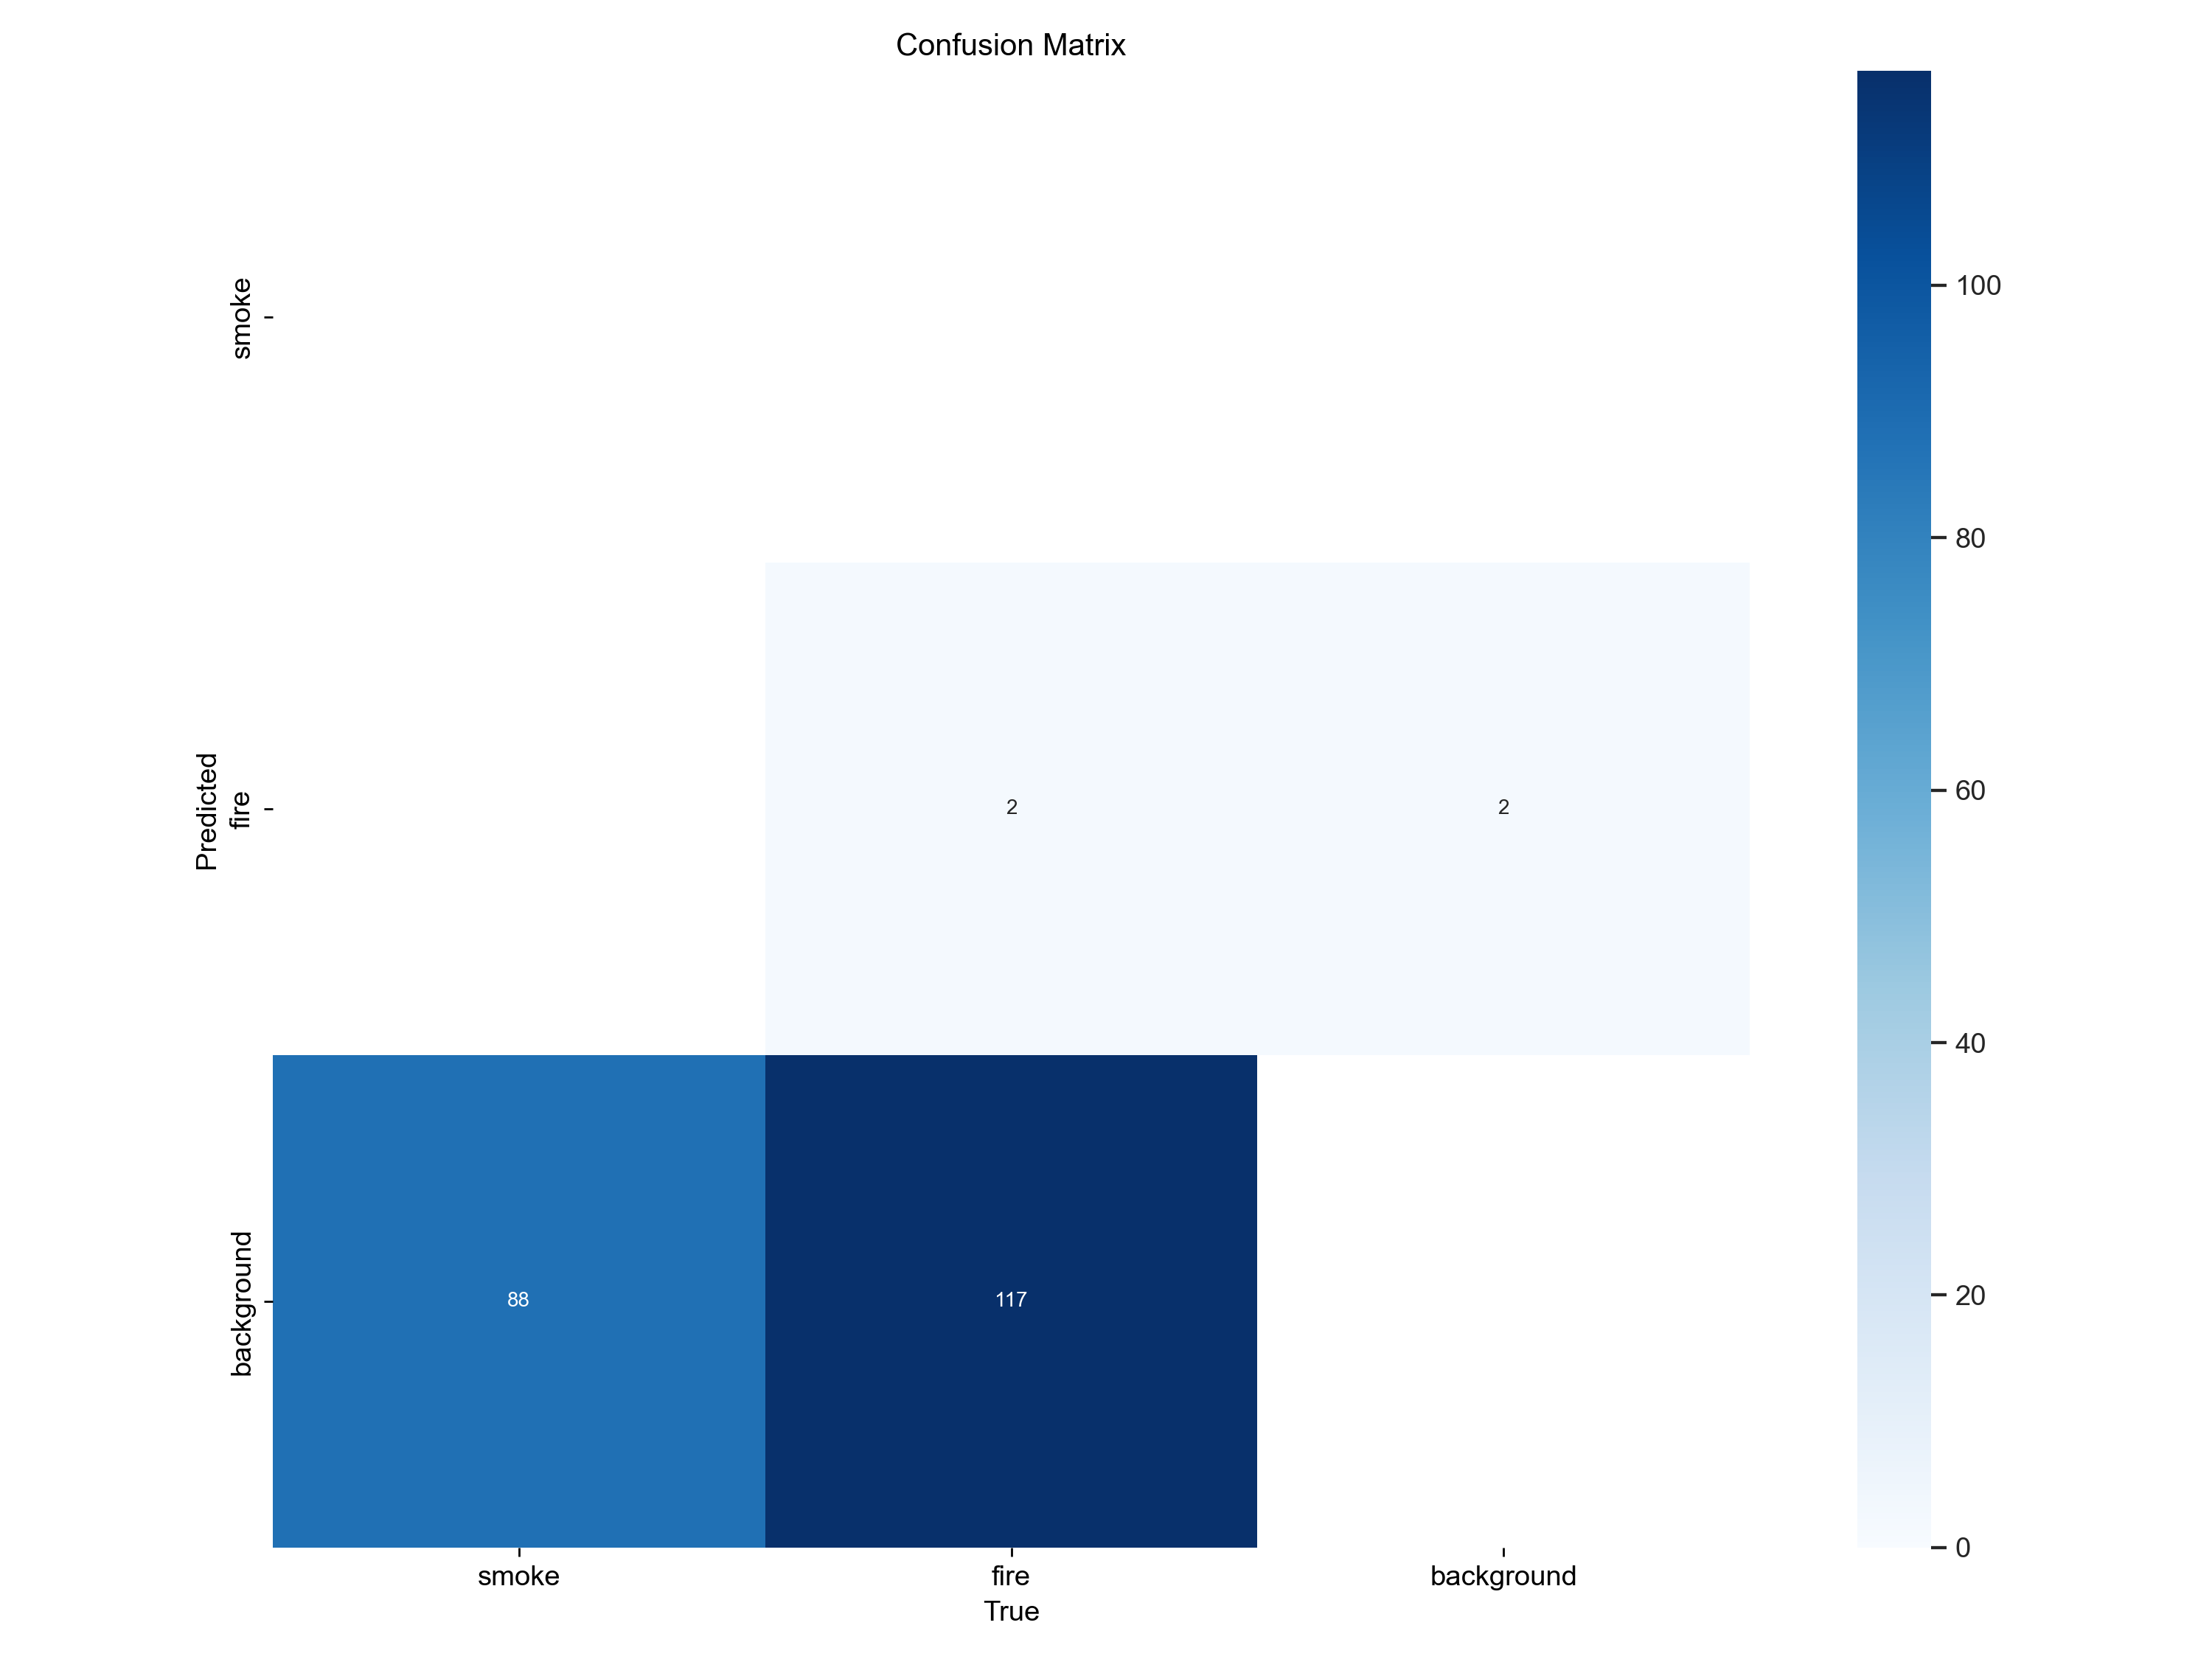

In [46]:
Image.open(f"runs/detect/yolov8s_fire_aug3/confusion_matrix.png")

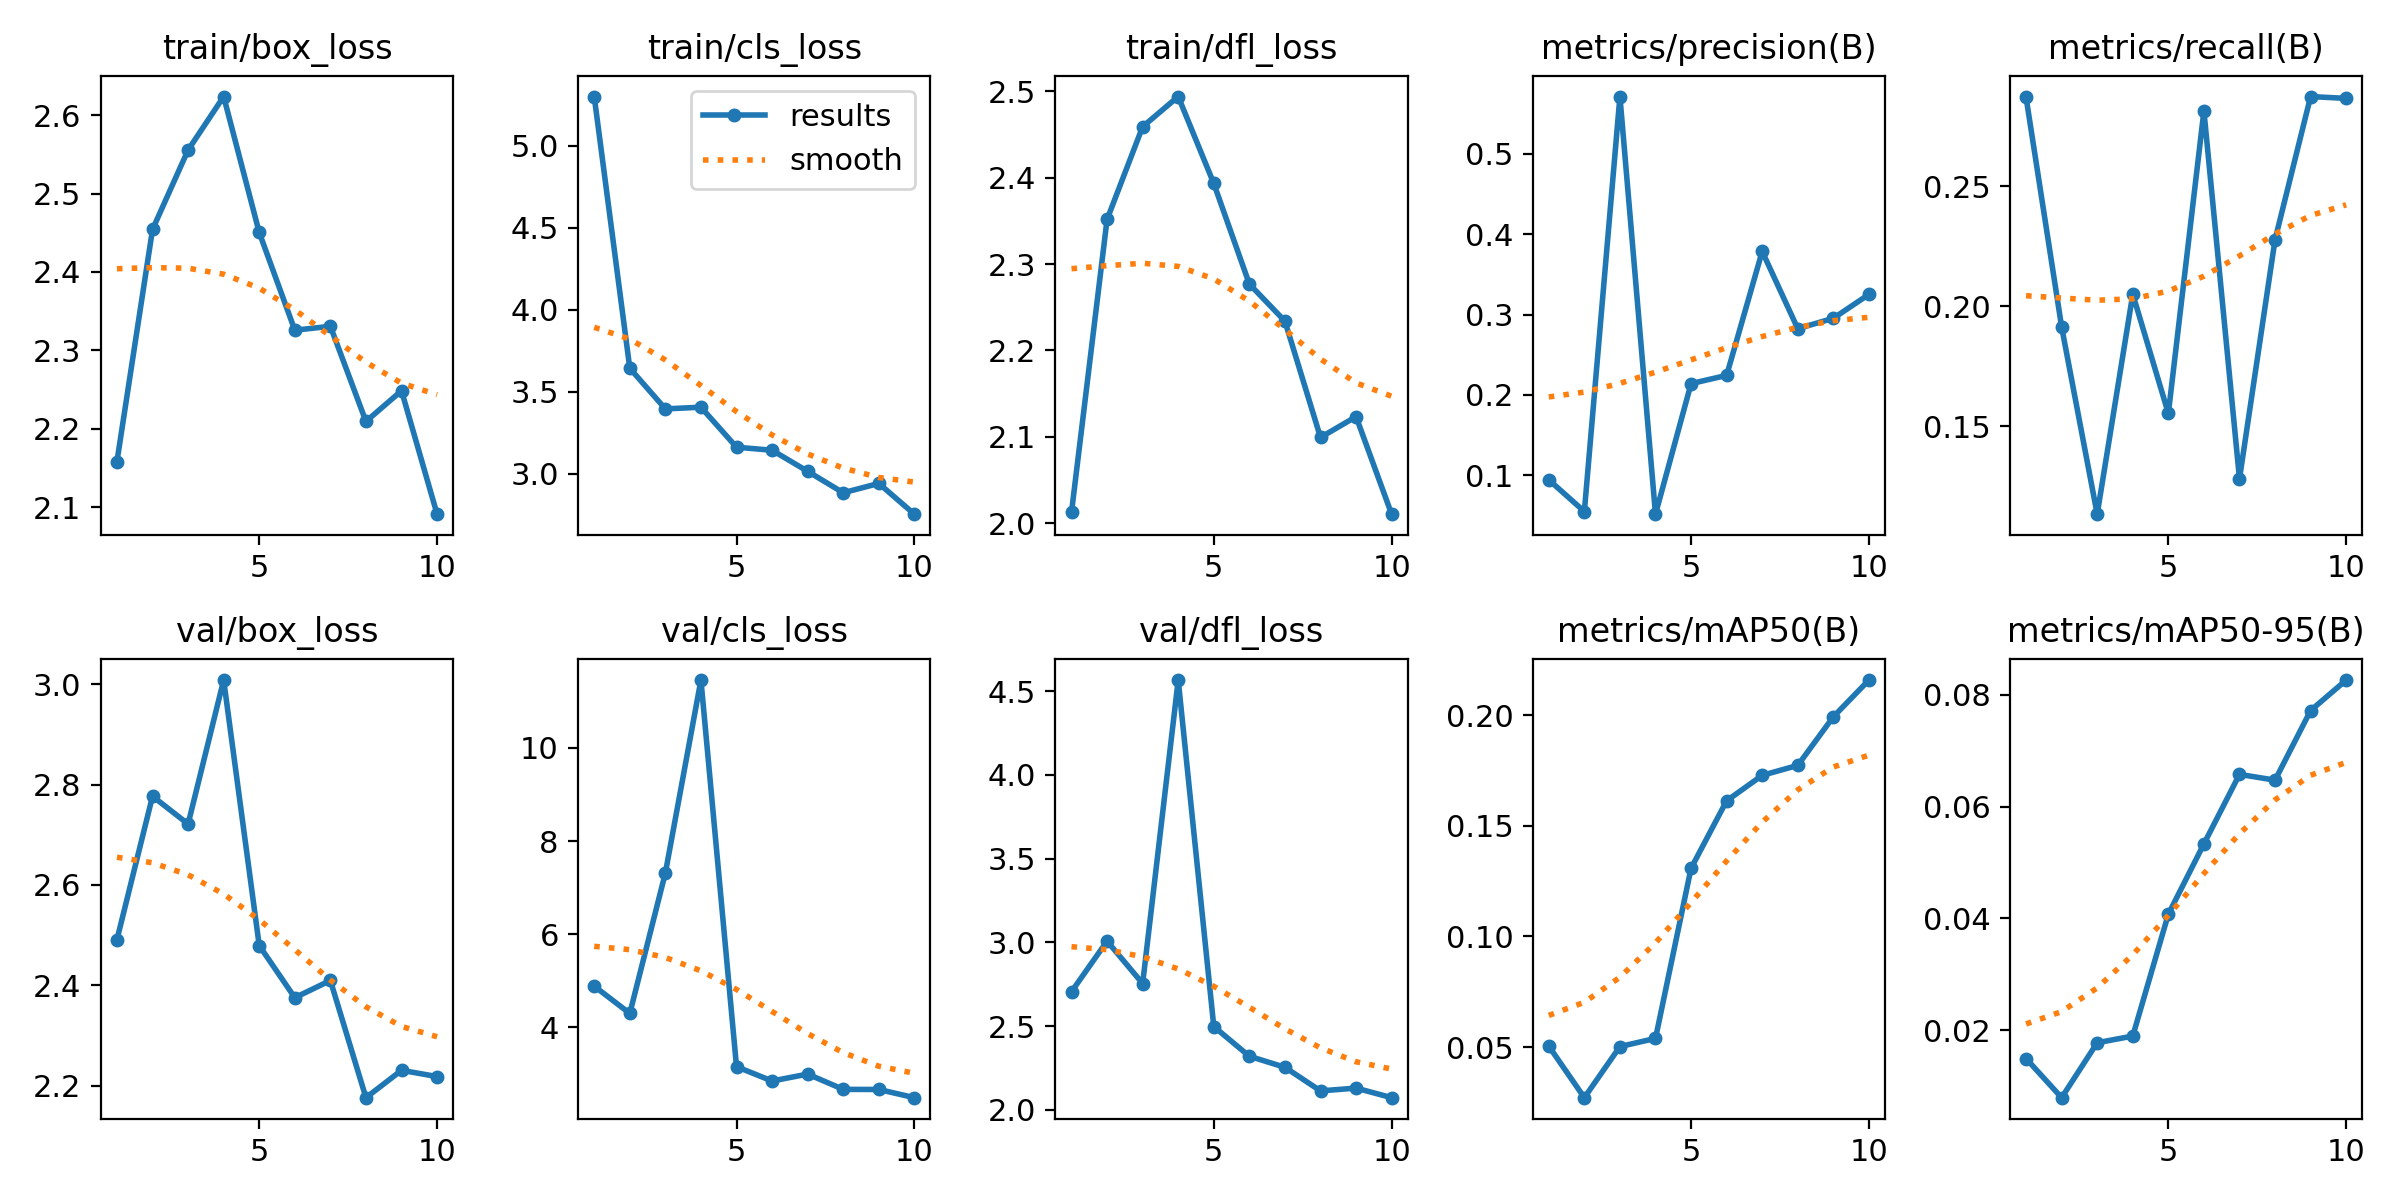

In [47]:
Image.open(f"runs/detect/yolov8s_fire_aug3/results.png")

### g. Выводы

Анализ графиков показывает, что применение аугментаций привело к снижению метрик качества модели. Возможно, это связано с недостаточным объёмом данных или количеством эпох

## 4. Имплементация алгоритма машинного обучения 

Загружаем датасет

In [27]:
with open(path + '/data.yaml') as f:
    data_config = yaml.safe_load(f)

train_img_dir = path + '/' + data_config.get('train', '')
val_img_dir =  path + '/' + data_config.get('val', '')

train_label_dir =  data_config.get('train_labels', train_img_dir.replace('images', 'labels'))
val_label_dir =  data_config.get('val_labels',   val_img_dir.replace('images', 'labels'))

class_names = data_config.get('names', [])
num_classes = len(class_names)

Пишем даталоадер

In [28]:
class YoloDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=224, S=7, B=1, C=20, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('jpg','jpeg','png'))]
        self.img_size = img_size
        self.S = S
        self.B =B
        self.C=C
        self.transform = transform if transform else T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, os.path.splitext(self.img_files[idx])[0] + '.txt')
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        target = torch.zeros((self.S, self.S, 5*self.B + self.C))
        boxes = []
        labels = []

        if os.path.exists(label_path):
            for line in open(label_path, 'r').read().splitlines():
                cls, x_ctr, y_ctr, w, h = map(float, line.split())
                cls = int(cls)

                i = int(x_ctr * self.S)
                j = int(y_ctr * self.S)
                x_cell = x_ctr * self.S - i
                y_cell = y_ctr * self.S - j

                if target[j, i, 4] == 0:
                    target[j, i, 0] = x_cell
                    target[j, i, 1] = y_cell
                    target[j, i, 2] = w
                    target[j, i, 3] = h
                    target[j, i, 4] = 1
                    target[j, i, 5 + cls] = 1

                x_abs = x_ctr * self.img_size
                y_abs = y_ctr * self.img_size
                w_abs = w * self.img_size
                h_abs = h * self.img_size
                x1 = x_abs - w_abs / 2
                y1 = y_abs - h_abs / 2
                x2 = x_abs + w_abs / 2
                y2 = y_abs + h_abs / 2
                boxes.append([x1, y1, x2, y2])
                labels.append(cls)

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes  else torch.zeros((0,4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        return img, target, boxes, labels
    
# Параметры
def collate_fn(batch):
    imgs = torch.stack([item[0] for item in batch], dim=0)
    yolo_targets = torch.stack([item[1] for item in batch], dim=0)
    boxes_list = [item[2] for item in batch]
    labels_list = [item[3] for item in batch]
    return imgs, yolo_targets, boxes_list, labels_list

img_size = 224
S = 7
B = 1
C = num_classes
batch_size = 16

train_dataset = YoloDataset(train_img_dir, train_label_dir, img_size, S, B, C)
val_dataset = YoloDataset(val_img_dir, val_label_dir,  img_size, S, B, C)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)


Архитектура модели

In [29]:
class SimpleYolo(nn.Module):
    def __init__(self, S=7, B=1, C=20):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C

        self.backbon = nn.Sequential(
            nn.Conv2d(3,16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(0.1), nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.1), nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.1), nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256,3, 1, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.1), nn.MaxPool2d(2,2),
            )
        self.pred = nn.Conv2d(256, self.B*5 + self.C, 1)

    def forward(self, x):
        x = self.backbon(x)
        x = self.pred(x)
        x = x.permute(0, 2, 3, 1)

        return x
    
model = SimpleYolo(S=S, B=B, C=C).to(device)

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=1, C=20, lambda_coord=5, lambda_noobj=0.5):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, preds, target):
        obj_mask = target[..., 4]
        noobj_mask = 1-obj_mask

        pred_box = torch.sigmoid(preds[..., :4])
        pred_obj = preds[..., 4]
        pred_cls = preds[..., 5:]
        tgt_box = target[..., :4]
        tgt_obj = target[..., 4]
        tgt_cls_oh = target[..., 5:]

        coord_loss = self.mse(obj_mask.unsqueeze(-1) * pred_box,obj_mask.unsqueeze(-1)*tgt_box)
        obj_loss = torch.sum(obj_mask* self.bce(pred_obj, tgt_obj))
        noobj_loss = torch.sum(noobj_mask *self.bce(pred_obj, tgt_obj))

        pred_cls_flat = pred_cls.reshape(-1, self.C)
        tgt_cls_ids = torch.argmax(tgt_cls_oh, dim=-1).reshape(-1)
        cls_loss_all = self.ce(pred_cls_flat, tgt_cls_ids)
        cls_loss = torch.sum(obj_mask.reshape(-1) * cls_loss_all)

        total_loss = (self.lambda_coord * coord_loss + obj_loss + self.lambda_noobj * noobj_loss + cls_loss)
        
        return total_loss

loss_fn = YoloLoss(S=S, B=B, C=C).to(device)

### b. Обучение имплементированной модели

In [30]:
map50_metric = MeanAveragePrecision(iou_thresholds=[0.5])
map50_95_metric = MeanAveragePrecision()

def train_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for imgs, y_targets, _, _ in tqdm(loader, desc='Training', leave=False):
        imgs = imgs.to(device)
        y_targets = y_targets.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, y_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("loss: ", total_loss / len(loader))

def eval(loader, model, device, conf_thresh=0.0):
    model.eval()
    map50_metric.reset()
    map50_95_metric.reset()

    with torch.no_grad():
        for imgs, _, boxes_l, labels_l in loader:
            imgs = imgs.to(device)
            preds = model(imgs).cpu()

            for b in range(imgs.size(0)):
                det_boxes = []
                det_scores = []
                det_labels = []

                for i in range(S):
                    for j in range(S):
                        conf = torch.sigmoid(preds[b,i,j,4])
                        if conf < conf_thresh:
                            continue
                        x_cell, y_cell, w_cell, h_cell = torch.sigmoid(preds[b, i, j, :4])
                        x_center = (j + x_cell)/S
                        y_center = (i + y_cell)/S
                        w = w_cell
                        h = h_cell

                        x1 = (x_center-w/2) * img_size
                        y1 = (y_center-h/2) * img_size
                        x2 = (x_center + w/2) * img_size
                        y2 = (y_center + h/2) * img_size
                        det_boxes.append([x1, y1, x2, y2])

                        cls_probs = torch.softmax(preds[b, i, j, 5:], dim=-1)
                        cls_score, cls_idx = torch.max(cls_probs, dim=-1)
                        det_scores.append((conf * cls_score).item())
                        det_labels.append(cls_idx.item())

                if len(det_boxes) > 0:
                    batch_pred = {
                        'boxes': torch.tensor(det_boxes, dtype=torch.float32),
                        'scores': torch.tensor(det_scores, dtype=torch.float32),
                        'labels': torch.tensor(det_labels,  dtype=torch.int64)
                    }
                else:
                    batch_pred = {
                        'boxes':torch.zeros((0,4),  dtype=torch.float32),
                        'scores':torch.zeros((0,),dtype=torch.float32),
                        'labels':torch.zeros((0,), dtype=torch.int64)
                    }

                gt = {
                    'boxes':boxes_l[b].to(torch.float32),
                    'labels':labels_l[b]
                }

                map50_metric.update([batch_pred], [gt])
                map50_95_metric.update([batch_pred], [gt])

    res50 = map50_metric.compute()
    res50_95 = map50_95_metric.compute()

    print("val mAP50:", res50['map_50'])
    print("val mAP50-95:",res50_95['map'])
     
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    print(f"Epoch: {epoch + 1}")

    train_epoch(train_loader, model, optimizer,loss_fn, device)
    eval(val_loader, model, device)

Epoch: 1


loss:  192.141641852561
val mAP50: tensor(0.0068)
val mAP50-95: tensor(0.0012)
Epoch: 2


loss:  96.21720907661353
val mAP50: tensor(0.0076)
val mAP50-95: tensor(0.0016)
Epoch: 3


loss:  78.91442061006353
val mAP50: tensor(0.0102)
val mAP50-95: tensor(0.0022)
Epoch: 4


loss:  71.24874215715387
val mAP50: tensor(0.0098)
val mAP50-95: tensor(0.0017)
Epoch: 5


loss:  66.29016093993455
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)


### g. Обучение на улучшенном бейзлайне

In [31]:
model_improve = SimpleYolo(S=S, B=B, C=C).to(device)

for epoch in range(10):
    print(f"Epoch: {epoch + 1}")

    train_epoch(train_loader, model_improve, optim.AdamW(model_improve.parameters(), lr=1e-5), loss_fn, device)
    eval(val_loader, model, device)

Epoch: 1


loss:  223.63745931561073
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 2


loss:  161.5757494937168
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 3


loss:  132.88325731941822
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 4


loss:  115.59982775570302
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 5


loss:  104.35379834121532
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 6


loss:  96.52248832616914
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 7


loss:  90.58848366040861
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 8


loss:  85.9937836507733
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 9


loss:  82.5753996774052
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)
Epoch: 10


loss:  79.41600105199922
val mAP50: tensor(0.0215)
val mAP50-95: tensor(0.0054)


### j. Выводы

Метрики ухудшились, скорее всего это связно с настройкой learning rate